In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # For visualization
from sklearn.ensemble import RandomForestClassifier  # Random Forest for bagging
from sklearn.tree import DecisionTreeClassifier  # Decision Tree model
from sklearn.tree import export_graphviz  # To visualize the decision tree
from sklearn.metrics import roc_curve, auc  # ROC and AUC curve for model evaluation
from sklearn.metrics import classification_report  # Classification report for decision trees
from sklearn.metrics import confusion_matrix  # Confusion matrix
from sklearn.model_selection import train_test_split  # Split dataset into train and test sets
from scipy.stats import pearsonr
import shap  # For SHAP values
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from scipy.interpolate import splev, splrep
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

# 1 Import data 

In [2]:
dt = pd.read_csv(r'D:\002NationalPark\001Research1\003Analysis\training_data.csv', index_col=0)
dt.head(5)

,RM_dist,MW_dist,GS_dist,XV_dist,CR_dist,RR_dist,Water_dist,NDVI,TEM,DEM,Slope,Population,NPP,Vegetation,Builtup_dist,present
152944,342918.9051,404663.1268,29624.23884,40538.79691,40545.09897,86625.40564,36399.33869,0.456,16.699446,3424,1.308435,3,0.120827,4991,46913.04826,0
155641,342723.5518,404198.8228,28425.56963,39372.05467,39373.67436,85365.28314,35540.80878,0.820,18.192223,3422,0.448084,5,0.124442,4991,46875.21836,0
155582,342242.8113,403762.5789,28653.59779,39558.17487,39565.64348,85676.09911,35570.02076,0.696,16.202084,3412,0.971957,4,0.132564,4991,46181.95585,0
155642,342049.1866,403299.7177,27448.97353,38387.67814,38390.38065,84413.65187,34710.90552,0.860,19.672916,3420,0.695848,4,0.138532,4991,46165.19301,0
155692,341859.5800,402841.2894,26265.25517,37231.74061,37231.74061,83156.08989,33870.65747,0.712,20.113195,3409,2.029433,5,0.157077,4991,46191.74217,0


In [6]:
dt = pd.read_csv(r'D:\002NationalPark\001Research1\003Analysis\20231120Revision_model_compare\points_2020.csv', index_col=0)
dt.head(5)

,RM_dist,MW_dist,GS_dist,XV_dist,CR_dist,RR_dist,Water_dist,NDVI,TEM,DEM,Slope,Population,NPP,Vegetation,Builtup_dist
OBJECTID,,,,,,,,,,,,,,,
1,61011.39584,76723.18793,33544.34288,16303.19890,12430.32121,14135.74214,11308.62671,0.680,12.408334,4350,23.849653,18,0.214249,264,56621.03622
2,60023.74449,75729.72081,34543.56169,15512.75605,13299.45092,15135.61352,12075.06235,0.656,12.124090,4216,10.977098,16,0.212627,264,55658.60843
3,59036.50890,74736.42793,35542.82443,14697.78165,14185.83463,15000.33982,12854.97342,0.656,12.716250,4152,36.685566,2,0.200399,61,54697.52865
4,58049.71028,73743.31635,36542.12751,13882.48680,15086.43144,14155.84445,12234.87891,0.660,14.345277,4182,35.993233,2,0.231815,61,53737.86923
5,57063.37129,72750.39349,36247.18422,13088.03092,15998.84130,13332.87927,11527.82172,0.644,13.523182,4175,34.104263,3,0.245771,61,52779.70764


[1, 0]
[5, 4]
[9, 0]
[9, 1]
[9, 8]
[14, 9]


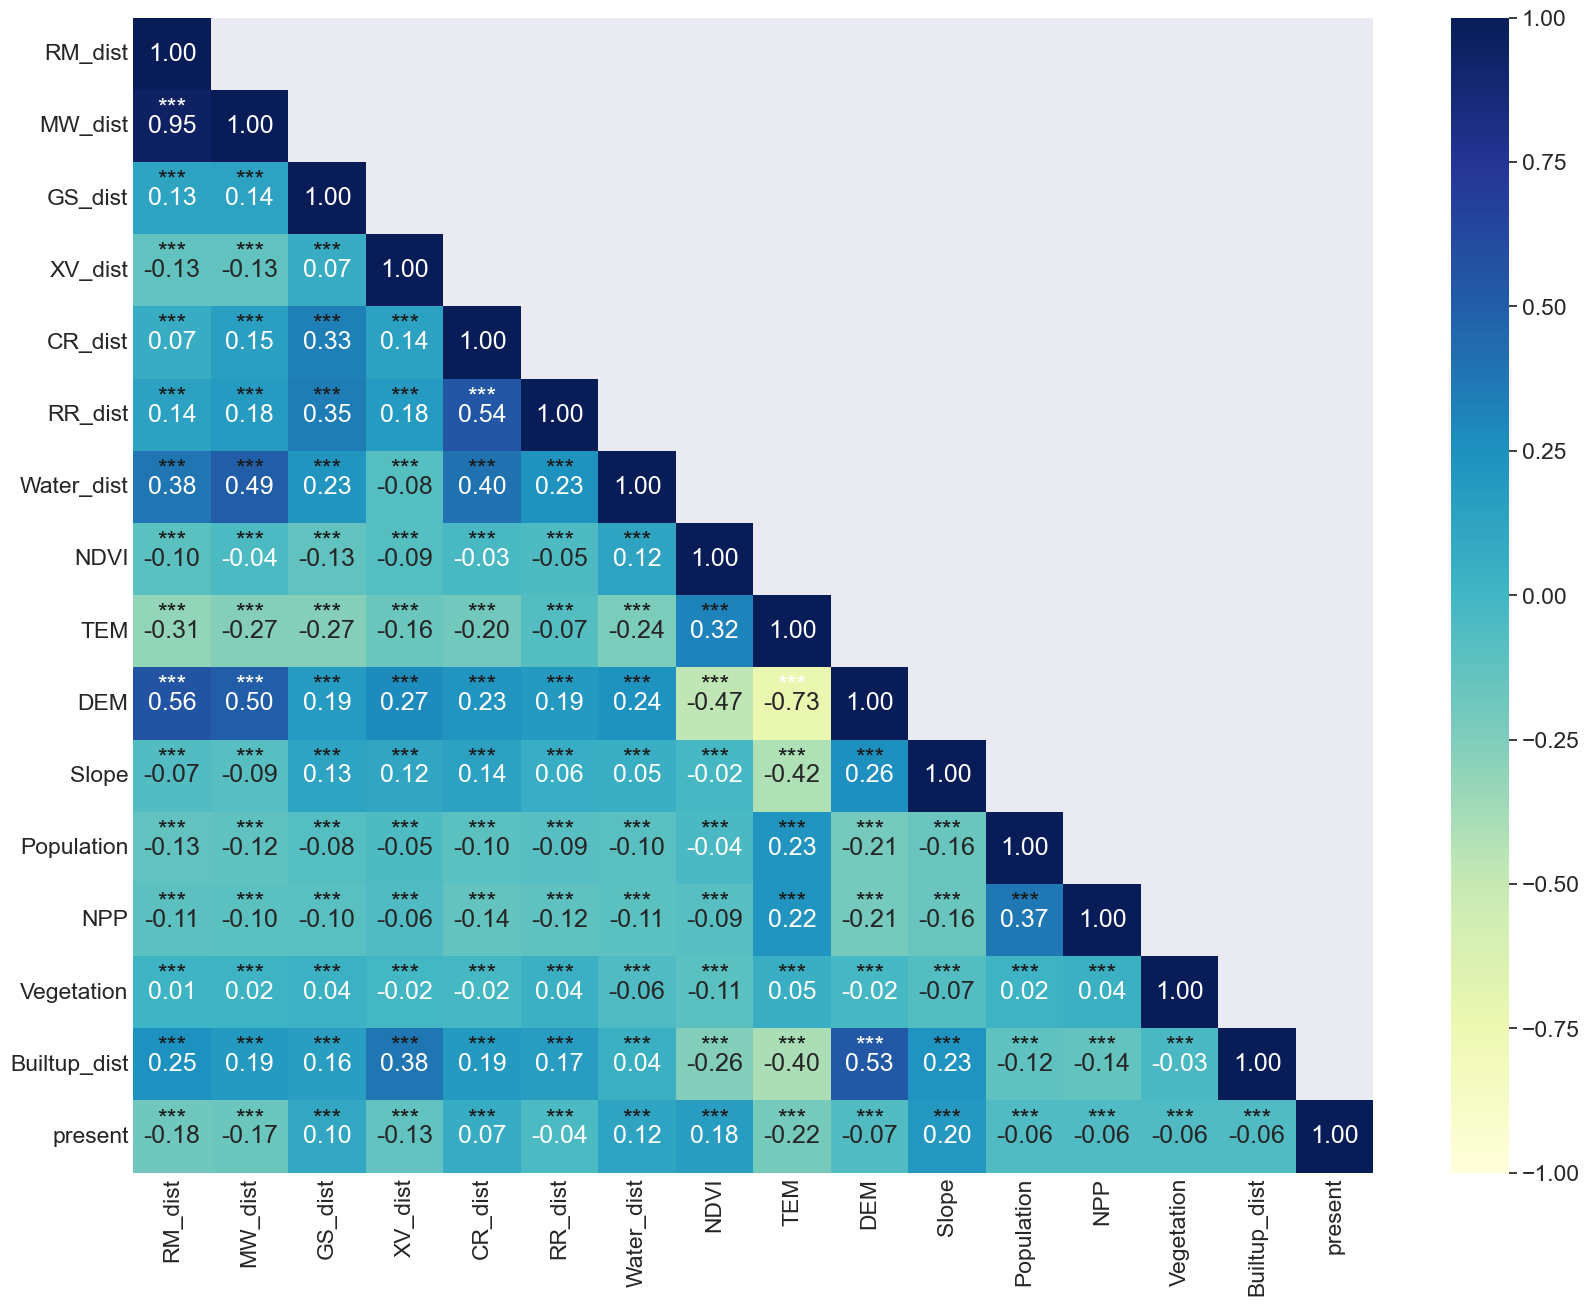

In [4]:
# Calculate correlation coefficients
df_corr = dt.corr()

# Set up the figure for the heatmap
fig = plt.figure(figsize=(20,15))
ax1 = plt.gca()

# Set font scale for the heatmap
sns.set(font_scale=1.5)

# Create a mask to remove duplicate data display (upper triangle)
mask = np.zeros_like(df_corr)  # Initialize mask with zeros
mask[np.triu_indices_from(mask)] = True  # Set upper triangle to True
mask2 = mask
# Rotate mask to cover only the upper triangle
mask = (np.flipud(mask) - 1) * (-1)
mask = np.rot90(mask, k=-1)

# Plot the heatmap with mask applied
im1 = sns.heatmap(df_corr, annot=True, cmap="YlGnBu", mask=mask,
                  vmax=1, vmin=-1, fmt='.2f', ax=ax1)

# Remove tick marks
ax1.tick_params(axis='both', length=0)

# Calculate correlation significance and display significance stars
rlist = []
plist = []
for i in dt.columns.values:
    for j in dt.columns.values:
        r, p = pearsonr(dt[i], dt[j])  # Calculate Pearson correlation and p-value
        rlist.append(r)
        plist.append(p)

# Reshape the lists into arrays for correlation and p-values
rarr = np.asarray(rlist).reshape(len(dt.columns.values), len(dt.columns.values))
parr = np.asarray(plist).reshape(len(dt.columns.values), len(dt.columns.values))

# Coordinates for placing significance markers
widthx = 0
widthy = -0.15

# Add significance stars based on p-values and correlation strength
for m in ax1.get_xticks():
    for n in ax1.get_yticks():
        pv = parr[int(m), int(n)]  # P-value
        rv = rarr[int(m), int(n)]  # Correlation coefficient
        if mask2[int(m), int(n)] < 1.:
            # Set color for the stars based on correlation strength
            color = 'white' if abs(rv) > 0.5 else 'k'
            if pv < 0.05 and pv >= 0.01:
                ax1.text(n + widthx, m + widthy, '*', ha='center', color=color)
            elif pv < 0.01 and pv >= 0.001:
                ax1.text(n + widthx, m + widthy, '**', ha='center', color=color)
            elif pv < 0.001:
                print([int(m), int(n)])
                ax1.text(n + widthx, m + widthy, '***', ha='center', color=color)

# Save the plot as an SVG file
# plt.savefig(r'D:\002NationalPark\001Research1\005Pic\corr_pvalue.svg')
plt.show()

# 2 Train the model

In [4]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dt.drop('present', axis=1), dt['present'], test_size=0.3, random_state=10)

In [1]:
# train the model
model = RandomForestClassifier()
# model = DecisionTreeClassifier(max_depth= 5)
model = model.fit(X_train,y_train)

In [7]:
feature_names = [i for i in X_train.columns]
print(feature_names)
y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'not habitat'
y_train_str[y_train_str == '1'] = 'habitat'
y_train_str = y_train_str.values

['RM_dist', 'MW_dist', 'GS_dist', 'XV_dist', 'CR_dist', 'RR_dist', 'Water_dist', 'NDVI', 'TEM', 'DEM', 'Slope', 'Population', 'NPP', 'Vegetation', 'Builtup_dist']


# 3 Model evaluation

In [25]:
# Predictions on the test set
y_predict = model.predict(X_test)
y_pred_quant = model.predict_proba(X_test)[:, 1]  # Probabilistic output
print(y_pred_quant)
print(y_predict)

[6.9946986e-01 6.3530443e-04 2.6664181e-04 ... 6.4588343e-03 9.0471894e-01
 9.5235354e-01]
[1 0 0 ... 0 1 1]


In [26]:
confusion_matrix = confusion_matrix(y_test, y_predict)
confusion_matrix

array([[39553,   628],
       [  713, 10054]], dtype=int64)

In [27]:
total_num = sum(sum(confusion_matrix))
precise = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
recall = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1])
acc = (confusion_matrix[0,0]+confusion_matrix[1,1])/total_num

print('precise:',precise)
print('recall:',recall)
print('acc:',acc)

precise: 0.982292753191278
recall: 0.9843707224807745
acc: 0.9736790453010913


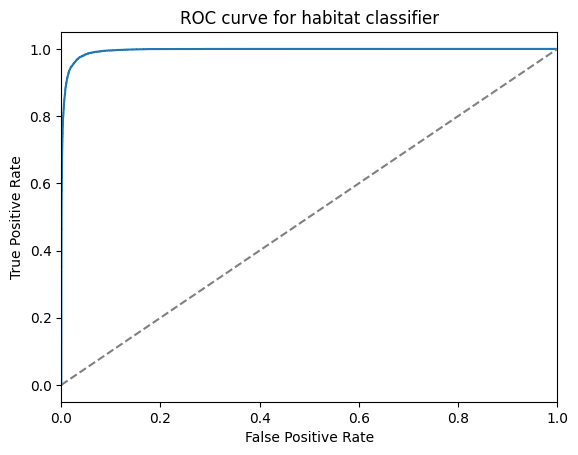

In [28]:
# Draw ROC curve
fpr,tpr,thresholds = roc_curve(y_test,y_pred_quant)

plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],ls='--',color='gray')
plt.xlim([0.0,1.0])
plt.plot([0.0],[1.0])
plt.title('ROC curve for habitat classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.savefig(r'D:\002NationalPark\001Research1\003Analysis\20230527RF\ROC.svg')
plt.show()

# 4 Model interpretation

## 4.1 Feature importance

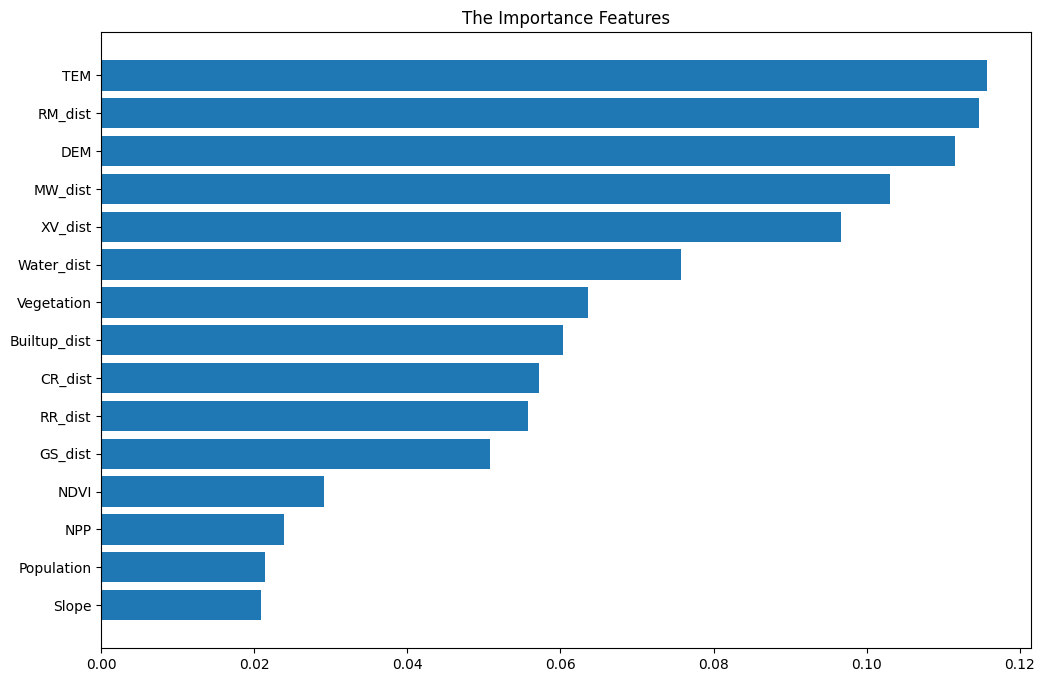

In [10]:
fea = dt.columns[:15]
b = pd.DataFrame()
b['feature'] = fea
b['importance'] = model.feature_importances_
b = b.sort_values('importance',ascending = True)
plt.figure(figsize=(12,8))
plt.barh(b['feature'],b['importance'])
plt.title('The Importance Features')
# plt.savefig(r'D:\002NationalPark\001Research1\003Analysis\20230527RF\importance.svg')
plt.show()

Feature ranking:
 1) TEM              0.115746
 2) RM_dist          0.114712
 3) DEM              0.111518
 4) MW_dist          0.103030
 5) XV_dist          0.096605
 6) Water_dist       0.075710
 7) Vegetation       0.063538
 8) Builtup_dist     0.060324
 9) CR_dist          0.057241
10) RR_dist          0.055696
11) GS_dist          0.050789
12) NDVI             0.029042
13) NPP              0.023825
14) Population       0.021388
15) Slope            0.020836


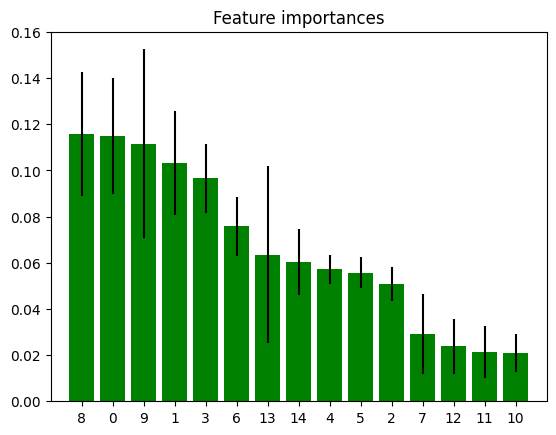

In [11]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]# Print the feature ranking
print("Feature ranking:")
for f in range(min(16,X_train.shape[1])):    
    print("%2d) %-*s %f" % (f + 1, 16, X_train.columns[indices[f]], importances[indices[f]]))# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],  color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
# plt.savefig(r'D:\002NationalPark\001Research1\003Analysis\20230527RF\importance.svg')
plt.show()

## 4.2 One-way PDP sample

<class 'numpy.ndarray'>
[0.22451407 0.22453857 0.22462724 0.22535644 0.22696611 0.22791509
 0.23388652 0.23724013 0.24002148 0.24381246 0.2515803  0.26394787
 0.27017455 0.27342896 0.27343475 0.27420438 0.2762296  0.27614941
 0.27614941 0.27613418 0.27602087 0.27515081 0.27537426 0.27456245
 0.27464393 0.2740822  0.27365177 0.27350939 0.27324105 0.27287362
 0.2693065  0.26886258 0.26609282 0.26525177 0.26409264 0.24450749
 0.21548848 0.21238815 0.20631668 0.2014914  0.19748132 0.1868672
 0.17636904 0.16455452 0.15905738 0.15889143 0.1586398  0.15853603
 0.15797584 0.15797584]


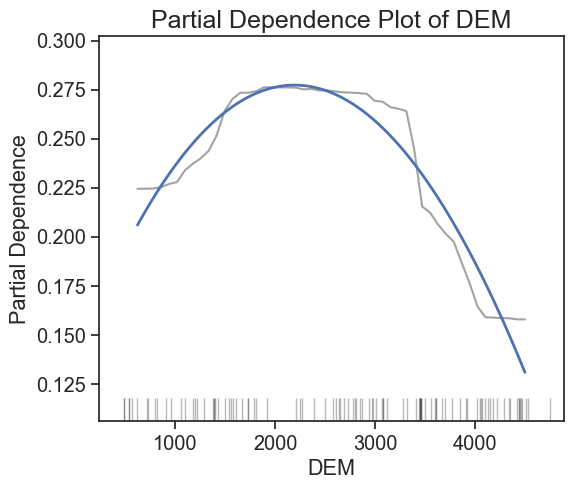

In [10]:
# Set theme for Seaborn plots
sns.set_theme(style="ticks", palette="deep", font_scale=1.3)

# Initialize the figure and axis
fig = plt.figure(figsize=(6, 5), dpi=100)
ax = plt.subplot(111)

# Define the feature for Partial Dependence Plot (PDP)
i = 'DEM'

# Calculate the partial dependence for the feature 'DEM'
pdp = partial_dependence(model, X_train, [i], 
                         kind="average", 
                         method='brute', 
                         grid_resolution=50)  # Get the PDP array

# Extract values for the x and y axes
plot_x = pdp['values'][0]  # Values for the x-axis
plot_y = pdp['average'][0]  # Average PDP values for the y-axis

# Print the type and values of plot_y for debugging purposes
print(type(plot_y))
print(plot_y)

# Smooth the data, refer to: https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html?highlight=interpolate
tck = splrep(plot_x, plot_y, s=30)  # Spline smoothing
xnew = np.linspace(plot_x.min(), plot_x.max(), 300)
ynew = splev(xnew, tck, der=0)

# Plot the original curve
plt.plot(plot_x, plot_y, color='k', alpha=0.4)

# Plot the smoothed curve
plt.plot(xnew, ynew, linewidth=2)

# Add a rug plot for the feature
sns.rugplot(data=dt.sample(100), x=i, height=.06, color='k', alpha=0.3)

# Define the x-axis limits to prevent outliers in the rug plot from affecting the scale
x_min = plot_x.min() - (plot_x.max() - plot_x.min()) * 0.1
x_max = plot_x.max() + (plot_x.max() - plot_x.min()) * 0.1

# Set title and labels
plt.title(f'Partial Dependence Plot of {i}', fontsize=18)
plt.ylabel('Partial Dependence')
plt.xlim(x_min, x_max)

# Uncomment to save the figure in SVG format
# plt.savefig(f'{i}.svg')

# Display the plot
plt.show()

## 4.3 Two-way PDP sample

NameError: name 'surf' is not defined

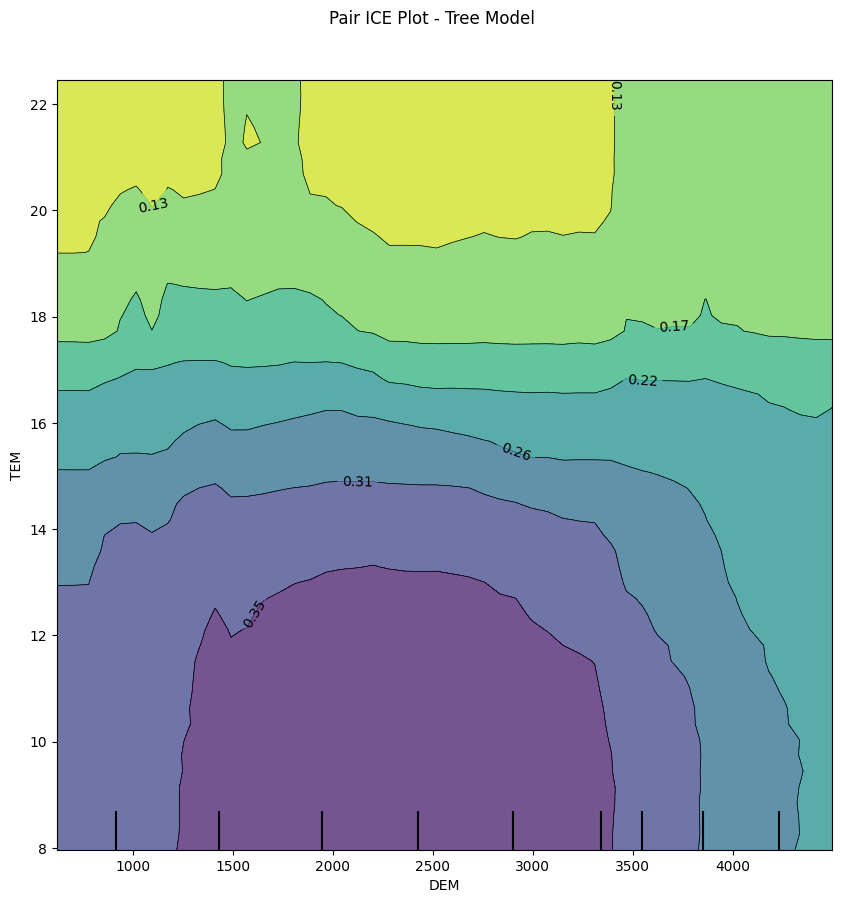

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))

features_to_display = [("DEM", "TEM")]

display_tree = PartialDependenceDisplay.from_estimator(
       estimator=model,
       X=X_train,
       features=features_to_display,
       subsample=50,
       n_jobs=3, 
       grid_resolution=50,
       random_state=42, 
       contour_kw={'cmap': 'viridis_r'},
       ax=ax
)

fig.suptitle(
       'Pair ICE Plot - Tree Model', y=0.95
)

fig.colorbar(surf);
plt.savefig('DEM_TEM'+'.svg')
plt.show()

## 4.4 SHAP

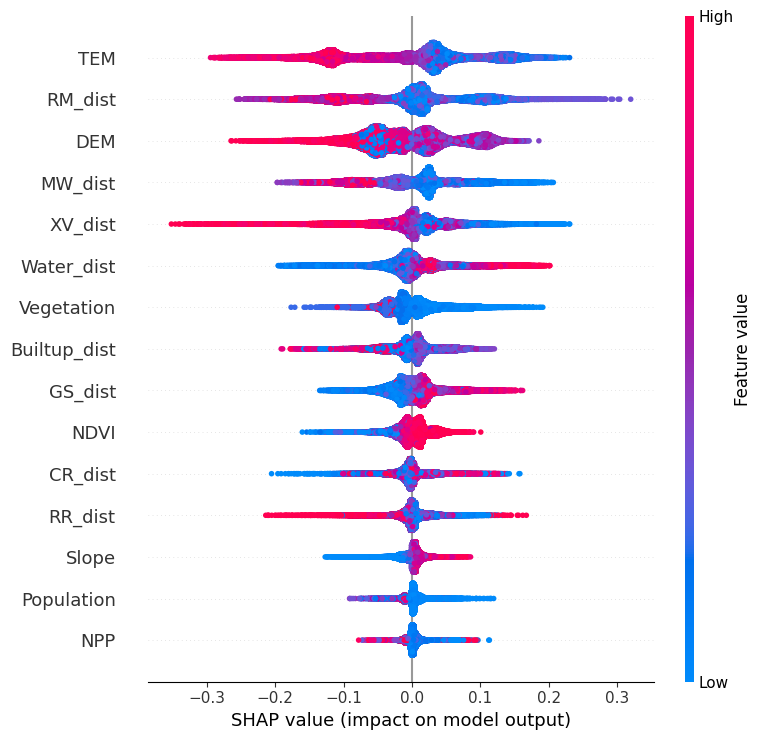

In [14]:
shap.summary_plot(shap_values[1],X_train)

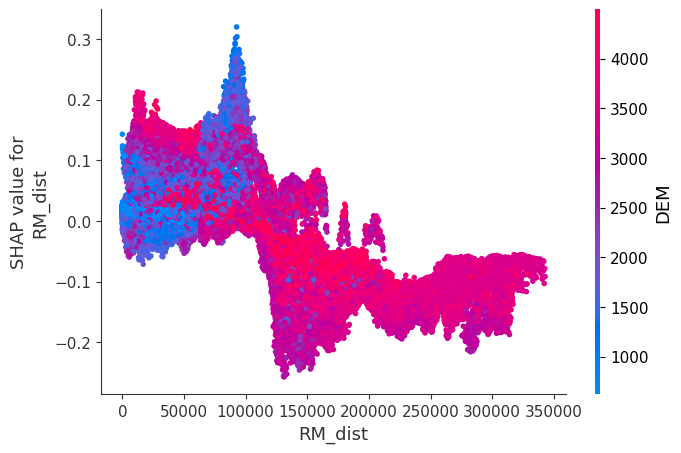

In [26]:
shap.dependence_plot('RM_dist', shap_values[1], X_train, interaction_index='DEM')

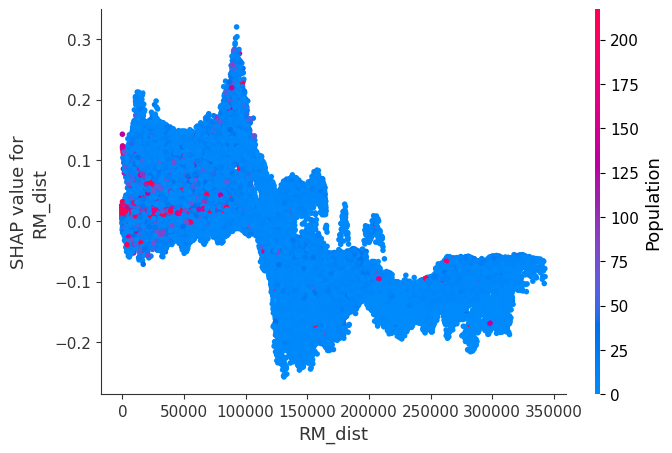

In [16]:
shap.dependence_plot('RM_dist', shap_values[1], X_train, interaction_index='Population')

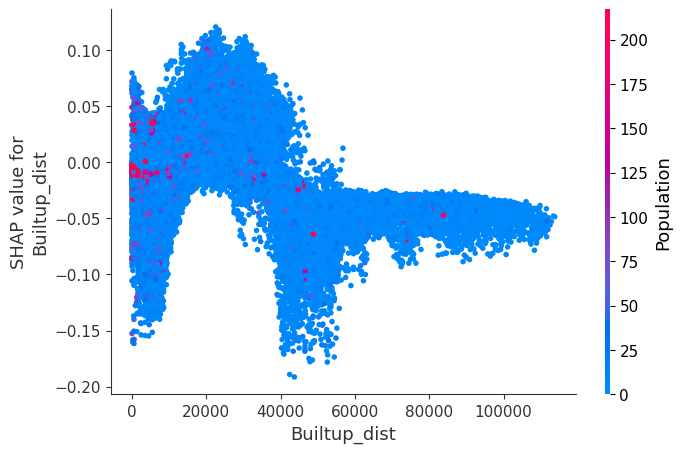

In [17]:
shap.dependence_plot('Builtup_dist', shap_values[1], X_train, interaction_index='Population')

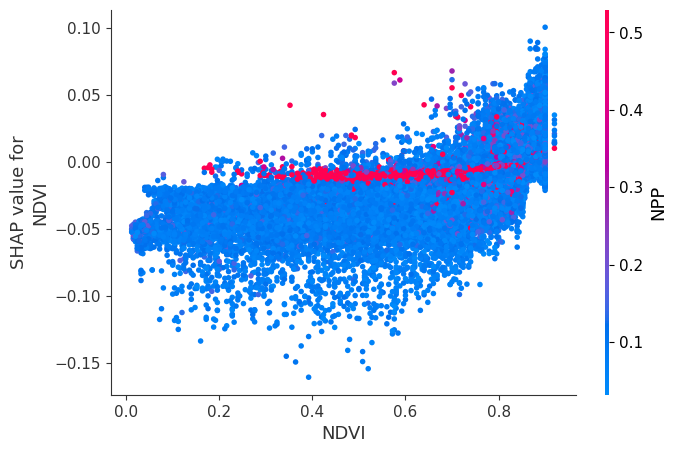

In [40]:
shap.dependence_plot('NDVI', shap_values[1], X_train, interaction_index='NPP')

In [ ]:
shap_values = explainer.shap_values(X_train.iloc[:50])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[:50])